In [37]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'} 

warnings.simplefilter('ignore')
COLOR = 'orange'
rcParams['figure.figsize'] = 8, 5
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

In [38]:
import json


def load_data(fp):
    with open(fp) as fid:
        series = (pd.Series(json.loads(s)) for s in fid)
        return pd.concat(series, axis=1).T

renththerunway_fp = './renttherunway_final_data.json'
df = load_data(renththerunway_fp)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


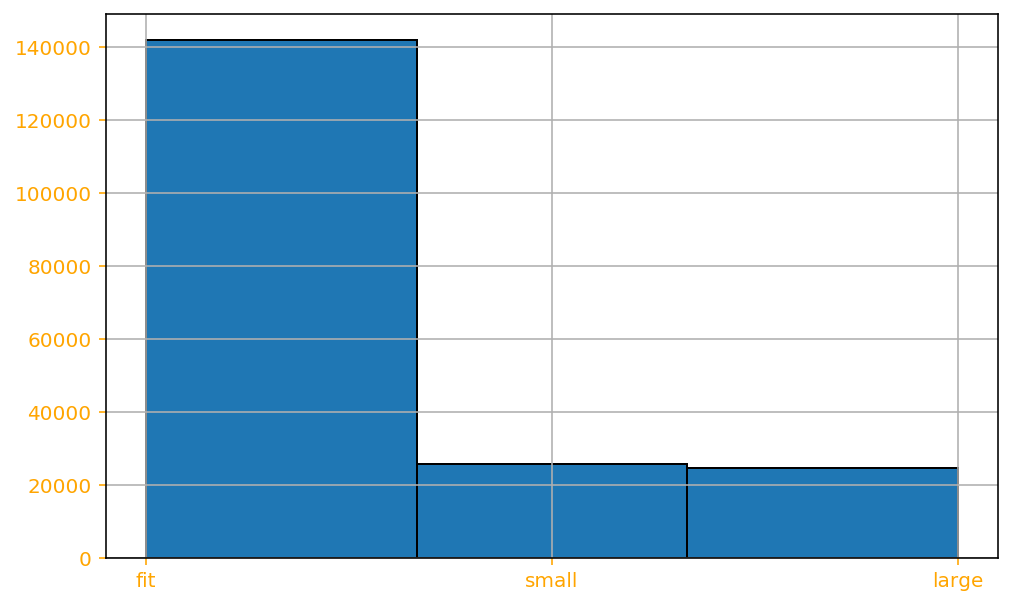

In [39]:
target_feature = 'fit'
n_classes = df[target_feature].unique().shape[0]
df[target_feature].hist(bins=n_classes, edgecolor='black');

Target variable has more observations in 'fit' class than the others. The dataset is unbalanced.

In [40]:
def check_nulls(data):
    for col in df:
        print(f'Column \'{col}\'. Is null - {data[col].isnull().sum()}')
        
check_nulls(df)

Column 'fit'. Is null - 0
Column 'user_id'. Is null - 0
Column 'bust size'. Is null - 18411
Column 'item_id'. Is null - 0
Column 'weight'. Is null - 29982
Column 'rating'. Is null - 82
Column 'rented for'. Is null - 10
Column 'review_text'. Is null - 0
Column 'body type'. Is null - 14637
Column 'review_summary'. Is null - 0
Column 'category'. Is null - 0
Column 'height'. Is null - 677
Column 'size'. Is null - 0
Column 'age'. Is null - 960
Column 'review_date'. Is null - 0


Columns 'bust size', 'weight', 'body type' contain the major of all missing values. Replacing them with most pobable values would make the dataset messy enough.

In [41]:
df[df['fit'] == 'fit'].isnull().sum()

fit                   0
user_id               0
bust size         13671
item_id               0
weight            22324
rating               63
rented for            9
review_text           0
body type         10903
review_summary        0
category              0
height              486
size                  0
age                 706
review_date           0
dtype: int64

As the dataset contains a lot of examples with target class 'fit', we may drop some having missing features.

In [42]:
to_drop = df[df['fit'] == 'fit'].isnull().any(axis=1)
n = to_drop.sum()
to_drop.shape, df.shape
df = df.drop(df[df['fit'] == 'fit'][to_drop].index, axis=0)
print(f'Dropped {n} examples')

Dropped 34325 examples


In [43]:
check_nulls(df)

Column 'fit'. Is null - 0
Column 'user_id'. Is null - 0
Column 'bust size'. Is null - 4740
Column 'item_id'. Is null - 0
Column 'weight'. Is null - 7658
Column 'rating'. Is null - 19
Column 'rented for'. Is null - 1
Column 'review_text'. Is null - 0
Column 'body type'. Is null - 3734
Column 'review_summary'. Is null - 0
Column 'category'. Is null - 0
Column 'height'. Is null - 191
Column 'size'. Is null - 0
Column 'age'. Is null - 254
Column 'review_date'. Is null - 0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158219 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             158219 non-null  object
 1   user_id         158219 non-null  object
 2   bust size       153479 non-null  object
 3   item_id         158219 non-null  object
 4   weight          150561 non-null  object
 5   rating          158200 non-null  object
 6   rented for      158218 non-null  object
 7   review_text     158219 non-null  object
 8   body type       154485 non-null  object
 9   review_summary  158219 non-null  object
 10  category        158219 non-null  object
 11  height          158028 non-null  object
 12  size            158219 non-null  object
 13  age             157965 non-null  object
 14  review_date     158219 non-null  object
dtypes: object(15)
memory usage: 19.3+ MB


All the columns were read as objects, so we need to convert them to their accurate datetypes.

In [45]:
cleaned_df = df.copy()

In [46]:
def feet_to_meters(s):
    feet, inches = map(int, s.replace("'", '').replace("\"", '').split())
    return feet * 0.3048 + inches * 0.0254

def pounds_to_kilos(s):
    return int(s.replace('lbs', '')) * 0.45359237

cleaned_df['height'] = (cleaned_df['height']
                        .fillna("0' 0\"")
                        .apply(feet_to_meters))
cleaned_df['height'][cleaned_df['height'] == 0] = cleaned_df['height'].median()

cleaned_df['weight'] = (cleaned_df['weight']
                        .fillna('0lbs')
                        .apply(pounds_to_kilos))
cleaned_df['weight'][cleaned_df['weight'] == 0.0] = cleaned_df['weight'].median()

cleaned_df['user_id'] = pd.to_numeric(cleaned_df['user_id'])
cleaned_df['bust size'] = cleaned_df['bust size'].fillna(cleaned_df['bust size'].value_counts().index[0])
cleaned_df['body type'] = cleaned_df['body type'].fillna(cleaned_df['body type'].value_counts().index[0])
cleaned_df['item_id'] = pd.to_numeric(cleaned_df['item_id'])
cleaned_df['size'] = pd.to_numeric(cleaned_df['size'])

cleaned_df['age'] = pd.to_numeric(cleaned_df['age'])
cleaned_df['age'] = cleaned_df['age'].fillna(cleaned_df['age'].median())

cleaned_df['rating'] = pd.to_numeric(cleaned_df['rating'])
cleaned_df['rating'] = cleaned_df['rating'].fillna(cleaned_df['rating'].median())

cleaned_df['review_date'] = pd.to_datetime(cleaned_df['review_date'], format='%B %d, %Y')
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158219 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             158219 non-null  object        
 1   user_id         158219 non-null  int64         
 2   bust size       158219 non-null  object        
 3   item_id         158219 non-null  int64         
 4   weight          158219 non-null  float64       
 5   rating          158219 non-null  float64       
 6   rented for      158218 non-null  object        
 7   review_text     158219 non-null  object        
 8   body type       158219 non-null  object        
 9   review_summary  158219 non-null  object        
 10  category        158219 non-null  object        
 11  height          158219 non-null  float64       
 12  size            158219 non-null  int64         
 13  age             158219 non-null  float64       
 14  review_date     158219 non-null  dat

Renaming columns to clarify what they correspond to.

In [47]:
col_mapper = {
    'bust size': 'bust_size',
    'weight': 'usr_weight_kg',
    'rating': 'review_rating',
    'rented for': 'rented_for',
    'body type': 'body_type',
    'category': 'product_category',
    'height': 'usr_height_meters',
    'size': 'product_size',
    'age': 'usr_age',
}
cleaned_df.rename(col_mapper, axis=1, inplace=True)

In [48]:
cleaned_df.head()

,fit,user_id,bust_size,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_meters,product_size,usr_age,review_date
0,fit,420272,34d,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,1.7272,14,28.0,2016-04-20
1,fit,273551,34b,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,1.6764,12,36.0,2013-06-18
3,fit,909926,34c,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,1.6510,8,34.0,2014-02-12
4,fit,151944,34b,616682,65.770894,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,1.7526,12,27.0,2016-09-26
5,fit,734848,32b,364092,62.595747,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,1.7272,8,45.0,2016-04-30


Now we should handle the categorial features left. I'll start with the 'bust_size' column.

In [49]:
import re


def parse_bust_size(s):
    m = re.match(r'(\d+)([A-Za-z])(\+?)', s)
    if m:
        return pd.Series(data=[int(m.group(1)), m.group(2).lower()])
    return []

mapper = {
    0: 'bust_size_num', 
    1: 'bust_size_cat'
}
temp_df = cleaned_df['bust_size'].apply(parse_bust_size).rename(mapper, axis=1)
temp_df['bust_size_num'] = pd.to_numeric(temp_df['bust_size_num'])
cleaned_df = cleaned_df.join(temp_df)
cleaned_df.drop(['bust_size'], axis=1, inplace=True)
cleaned_df.head()

,fit,user_id,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_meters,product_size,usr_age,review_date,bust_size_num,bust_size_cat
0,fit,420272,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,1.7272,14,28.0,2016-04-20,34,d
1,fit,273551,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,1.6764,12,36.0,2013-06-18,34,b
3,fit,909926,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,1.6510,8,34.0,2014-02-12,34,c
4,fit,151944,616682,65.770894,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,1.7526,12,27.0,2016-09-26,34,b
5,fit,734848,364092,62.595747,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,1.7272,8,45.0,2016-04-30,32,b


Now let's augment the data with samples of minority classes. I randomly pick half of the samples with fit status 'fit' and change their weight by some <code>weight_shift_kg</code> value. Obviously, newly-created examples will be either small or large. 

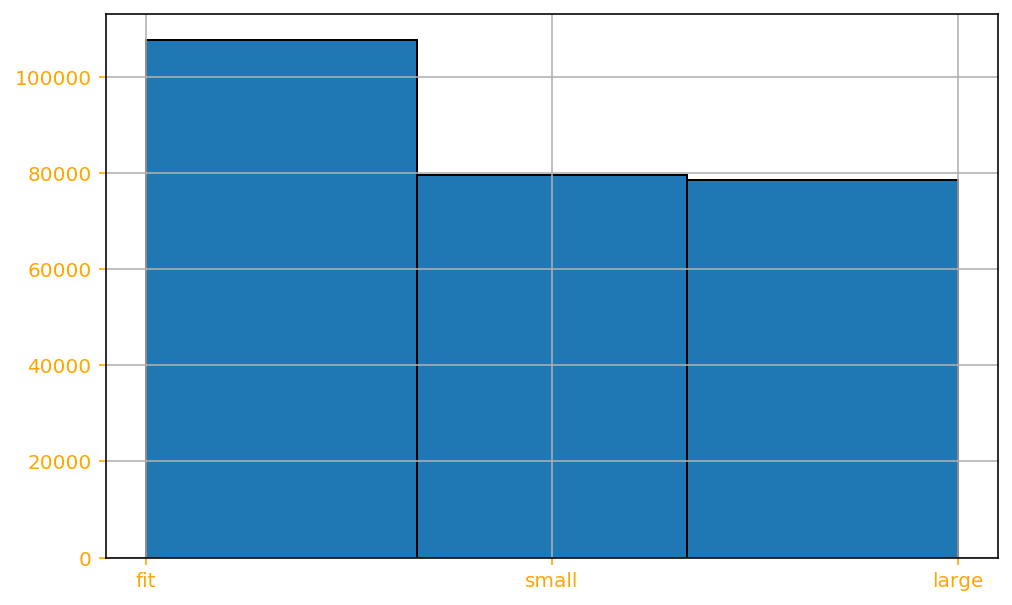

In [50]:
np.random.seed(69)

fit_samples = cleaned_df[(cleaned_df['fit'] == 'fit')]
selected_indices = np.random.choice(fit_samples.index, fit_samples.shape[0] // 2)
fit_samples = fit_samples.loc[selected_indices]
weight_shift_kg = 10.0

augm_small_samples = fit_samples.copy()
augm_small_samples['fit'] = 'small'
augm_small_samples['usr_weight_kg'] -= weight_shift_kg

augm_large_samples = fit_samples.copy()
augm_large_samples['fit'] = 'large'
augm_large_samples['usr_weight_kg'] += weight_shift_kg


cleaned_df = cleaned_df.append(pd.concat((augm_large_samples, augm_small_samples)), ignore_index=True).dropna()
cleaned_df[target_feature].hist(bins=n_classes, edgecolor='black');

In [51]:
with open('../app/model/txt/size_categories.txt') as fid:
    categories = fid.readline().split(',')

n_prod_size_cats = len(categories)
min_size, max_size = cleaned_df['product_size'].min(), cleaned_df['product_size'].max()
prod_size_shift = max_size / n_prod_size_cats
prod_size_shift

7.25

To handle the column 'bust_size' I converted it into two new features, one of which is oridinal ('bust_size_cat'), so we can easily handle it using label encoding.

In [52]:
def save_labels(fp, iterable, sep=','):
    with open(fp, 'w') as fid:
        fid.write(sep.join(iterable))

In [53]:
unique_cats = sorted(cleaned_df['bust_size_cat'].unique().tolist())
mapper = {unique_cats[i]:i+1 for i in range(len(unique_cats))}
save_labels('../app/model/txt/bust_size_categories.txt', mapper.keys())
cleaned_df['bust_size_cat'] = cleaned_df['bust_size_cat'].map(mapper)

The target feature is ordinal, so I treat it the same way.

In [54]:
mapper = {
    'small': -1,
    'fit': 0,
    'large': 1,
}
cleaned_df[target_feature] = cleaned_df[target_feature].map(mapper)
cleaned_df.head(3)

,fit,user_id,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_meters,product_size,usr_age,review_date,bust_size_num,bust_size_cat
0,0,420272,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,1.7272,14,28.0,2016-04-20,34,4
1,0,273551,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,1.6764,12,36.0,2013-06-18,34,2
2,0,909926,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,1.6510,8,34.0,2014-02-12,34,3


,fit,usr_weight_kg,usr_height_meters,product_size,usr_age,bust_size_num,bust_size_cat
fit,1.000000,0.447609,-0.007502,-0.055221,-0.007174,-0.006914,-0.003814
usr_weight_kg,0.447609,1.000000,0.321811,0.682779,0.054164,0.520471,0.243668
usr_height_meters,-0.007502,0.321811,1.000000,0.242123,-0.001996,0.158762,0.014793
product_size,-0.055221,0.682779,0.242123,1.000000,0.167535,0.637324,0.306039
usr_age,-0.007174,0.054164,-0.001996,0.167535,1.000000,0.185788,0.074130
bust_size_num,-0.006914,0.520471,0.158762,0.637324,0.185788,1.000000,0.113768
bust_size_cat,-0.003814,0.243668,0.014793,0.306039,0.074130,0.113768,1.000000


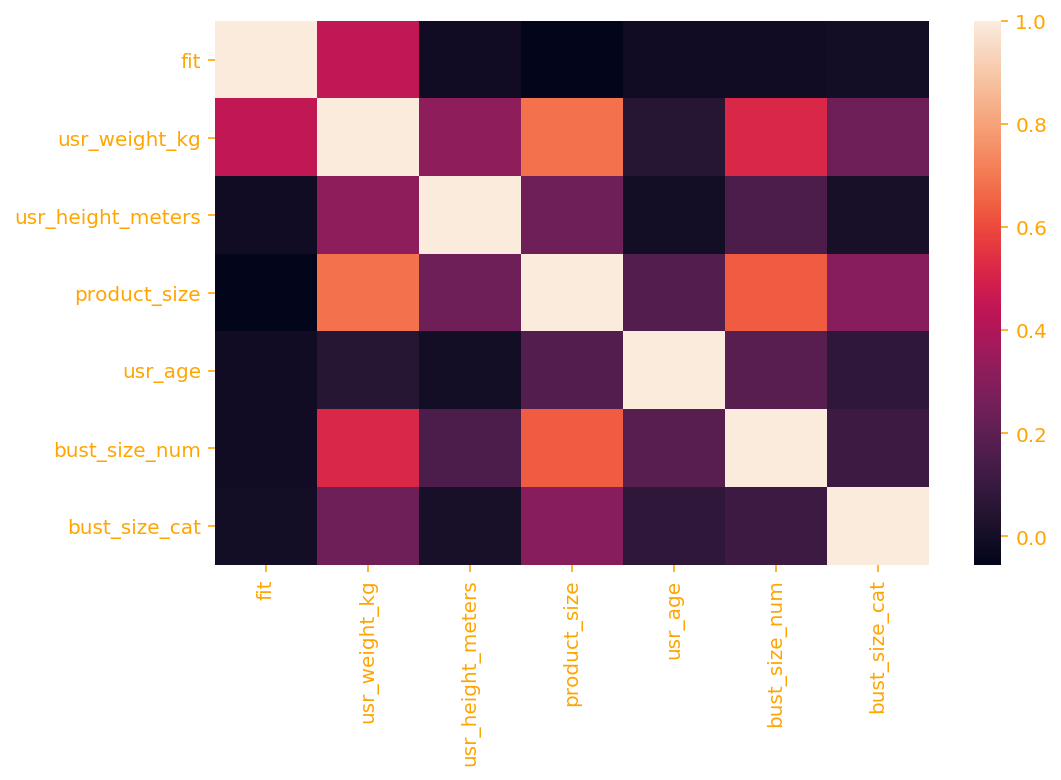

In [55]:
from sklearn.preprocessing import scale


numeric_dtypes = {'int64', 'float64'}
numeric_features = [c for c in cleaned_df.columns if str(cleaned_df[c].dtype) in numeric_dtypes]
numeric_features.remove('user_id')
numeric_features.remove('item_id')
numeric_features.remove('review_rating')

cleaned_df_scaled = cleaned_df[numeric_features].copy()
cleaned_df_scaled = pd.DataFrame(scale(cleaned_df_scaled), columns=numeric_features)

corr_matrix = cleaned_df_scaled.corr()
sns.heatmap(corr_matrix)
corr_matrix

Product size feature correlates well with the target feature

In [56]:
print('Pairs of columns that have correlation greater than 0.5: ')
lim = 0.5
corr_cols = []
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if corr_matrix.iloc[i, j] > lim:
            pair = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_cols.append(pair)
            print('({}, {})'.format(*pair))
            
print('These columns are to be inspected more closely')
corr_cols

Pairs of columns that have correlation greater than 0.5: 
(usr_weight_kg, product_size)
(usr_weight_kg, bust_size_num)
(product_size, bust_size_num)
These columns are to be inspected more closely


[('usr_weight_kg', 'product_size'),
 ('usr_weight_kg', 'bust_size_num'),
 ('product_size', 'bust_size_num')]

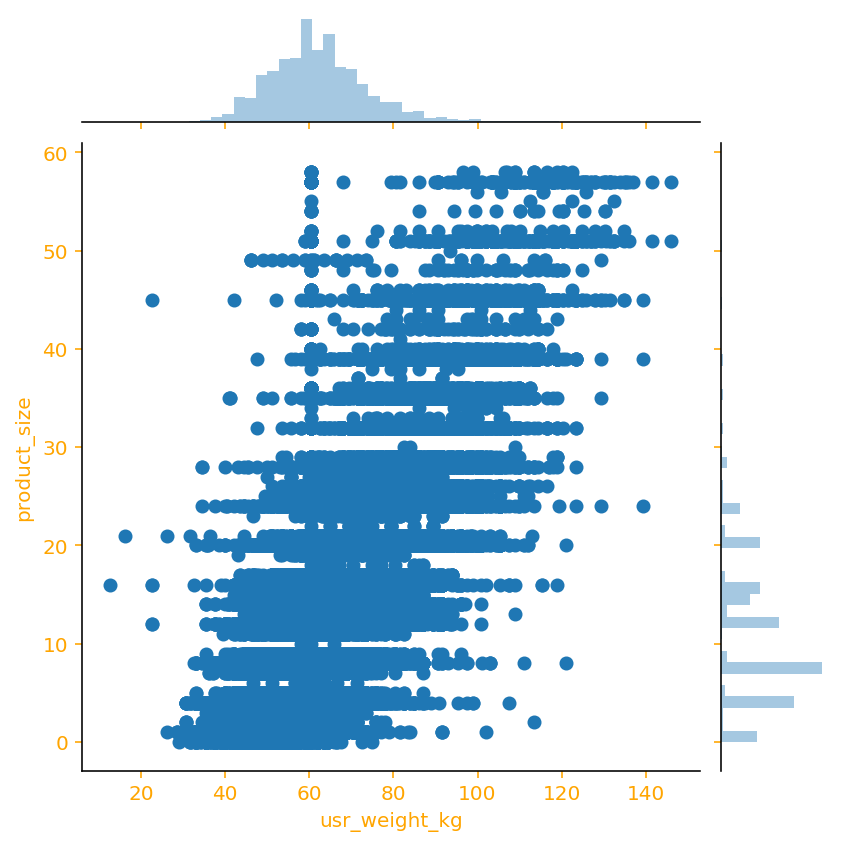

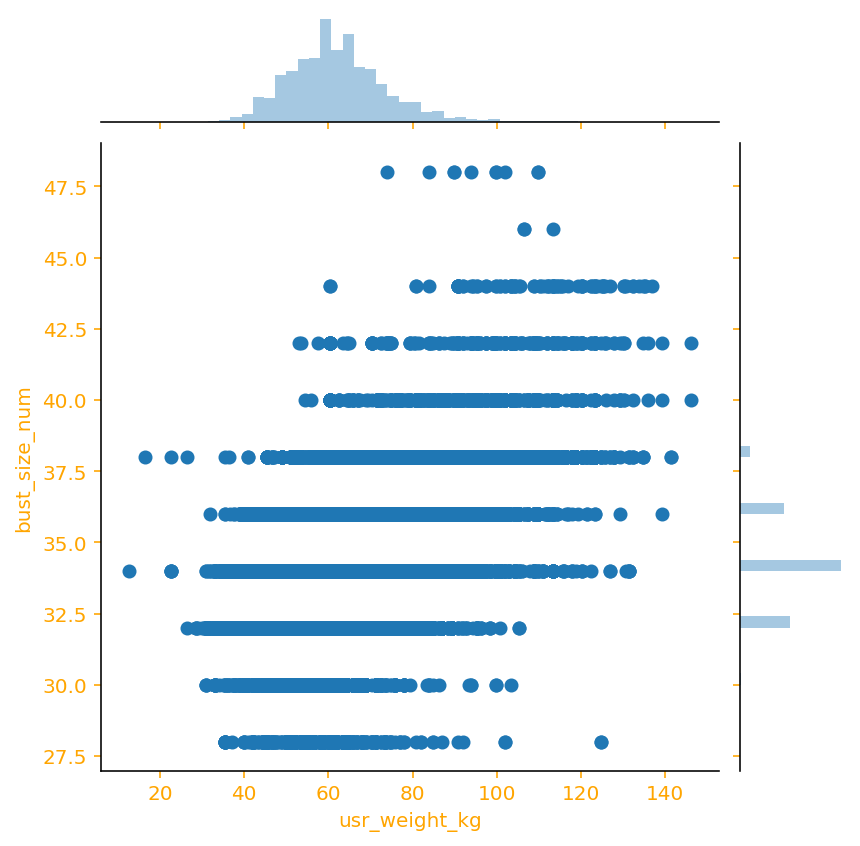

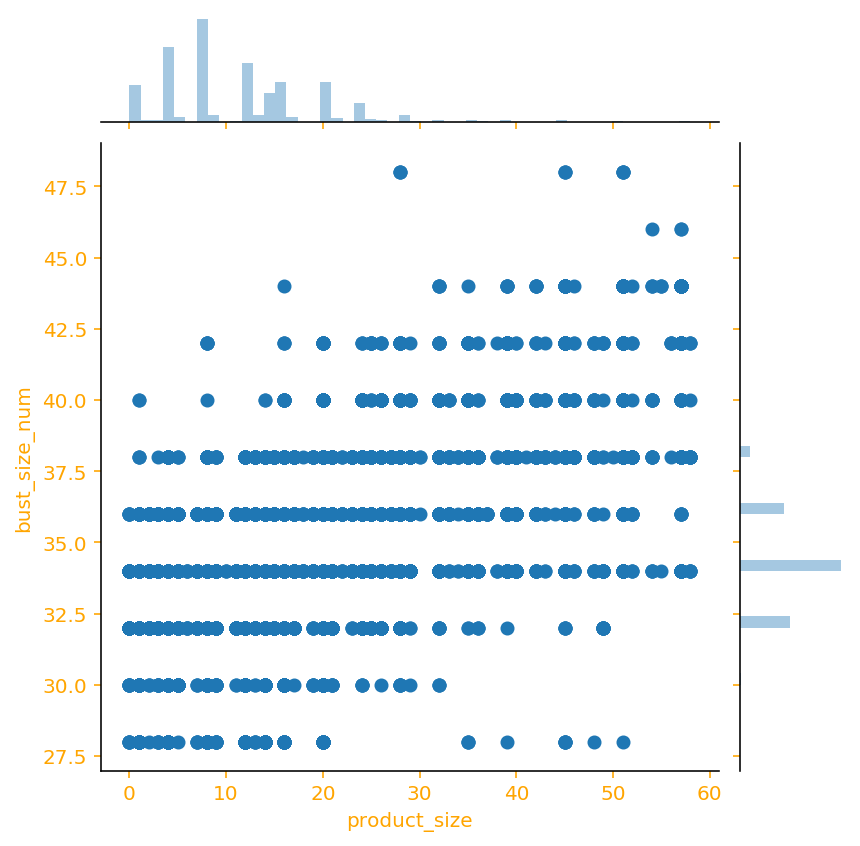

In [57]:
for x, y in corr_cols:
    sns.jointplot(x=x, y=y, data=cleaned_df)

plt.show()

1) Obviously, users of different weight categories (20-40kg, 40-60kg, etc) choose product sizes of some particular ranges (0-5, 5-10, etc respectively). Therefore, these two features can be used interchangeably. <br> <br>
2) In addition, users might have different bust sizes despite different weight categories. <br> <br>
3) Analogously, relationship between product sizes and bust sizes is the same as in (2) (consequence from (1))

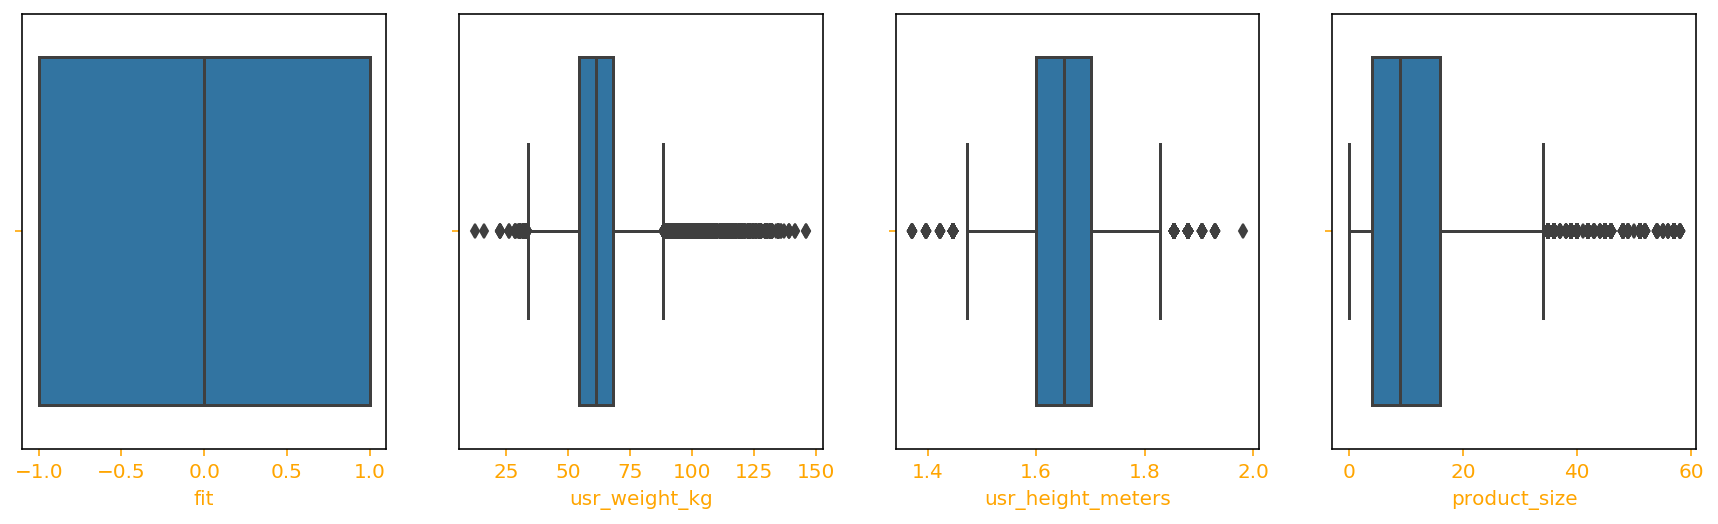

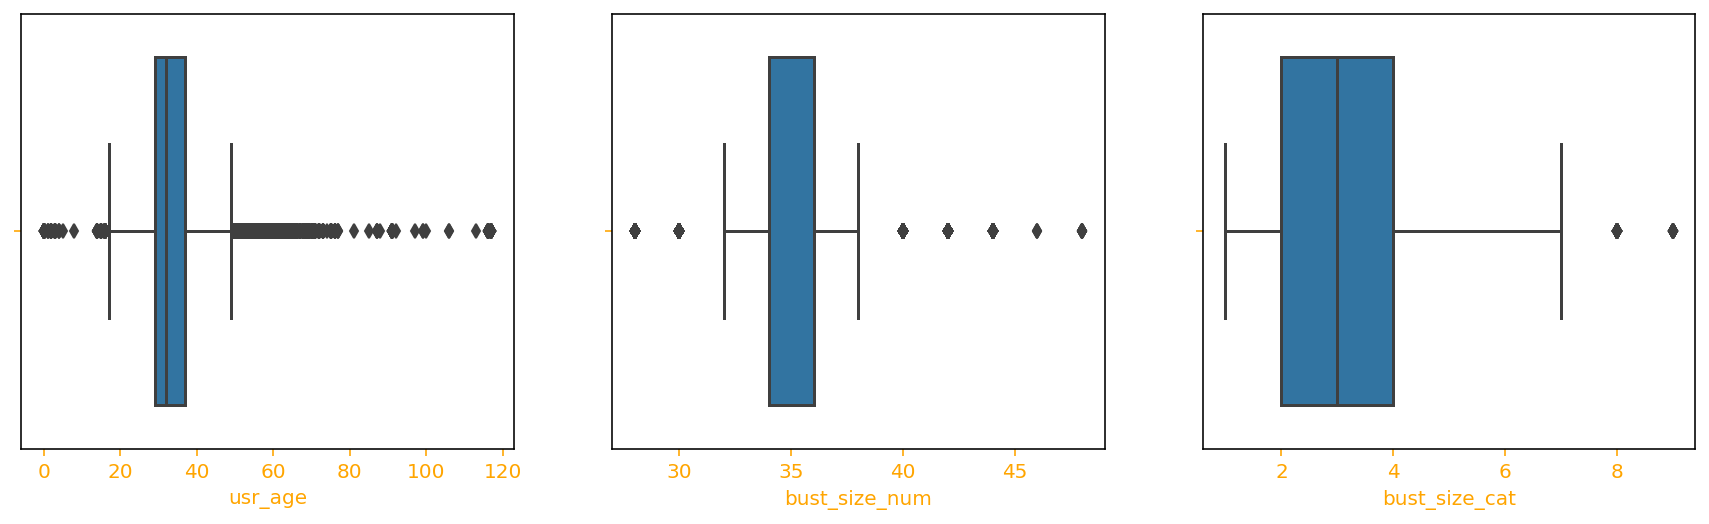

In [58]:
def draw_boxplots(cols, data, per_line=4):
    n = len(cols)
    per_line = 4
    for i in range(0, n, per_line):
        n_plots = per_line if n - i >= per_line else n % per_line
        fig, axes = plt.subplots(1, n_plots)
        plt.subplots_adjust(wspace=0.2)
        fig.set_figwidth(15)
        fig.set_figheight(4)
        for j in range(n_plots):
            sns.boxplot(data[cols[i + j]], ax=axes[j])
        plt.show()
        
draw_boxplots(numeric_features, cleaned_df)

Colomns 'usr_weight_kg', 'product_size' and 'usr_age' contain a lot of outliers. I'll fix it with robust sigma-cropping. 

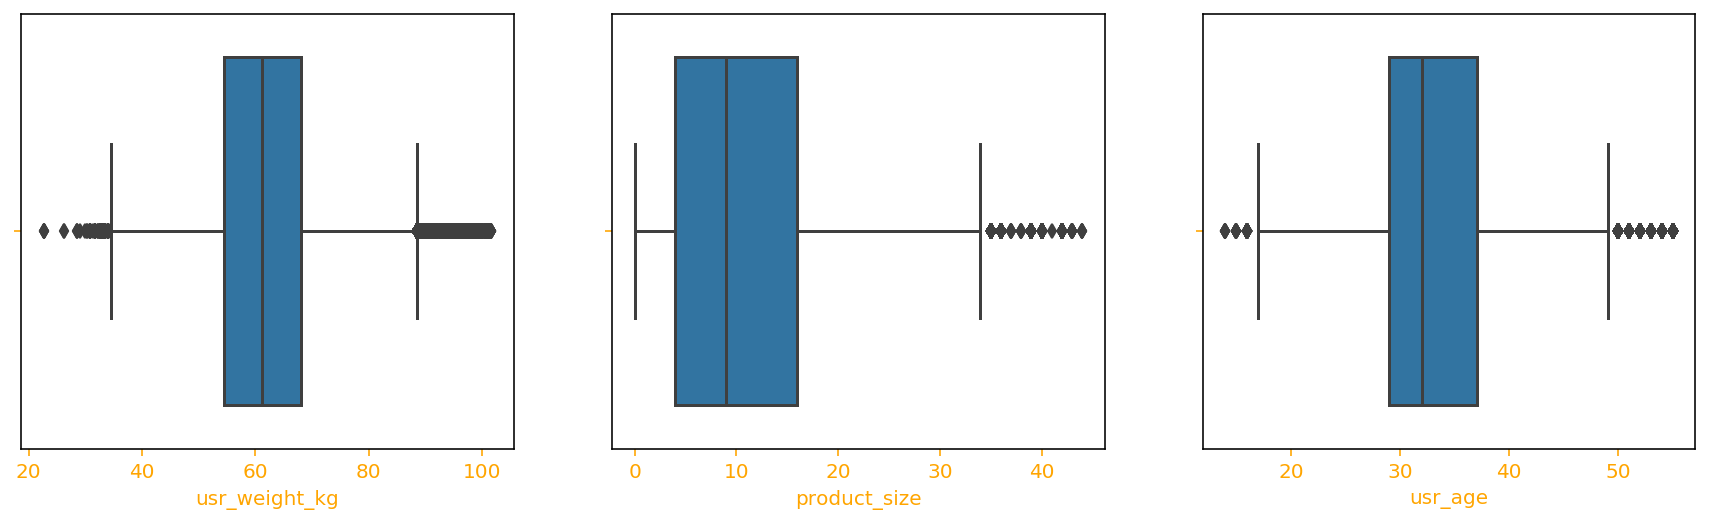

In [59]:
cols_with_outliers = ['usr_weight_kg', 'product_size', 'usr_age']

for c in cols_with_outliers:
    q1, q2, q3 = np.percentile(cleaned_df[c], [25, 50, 75])
    median = q2
    std = 0.7413 * (q3 - q1)
    query_result = cleaned_df.query(f'({c} > @median - 4 * @std) & ({c} < @median + 4 * @std)')[c]
    cleaned_df[c] = query_result
    cleaned_df[c] = cleaned_df[c].fillna(cleaned_df[c].median())
    
draw_boxplots(cols_with_outliers, cleaned_df)

Now based on the weight and height of a person we can calculate their BMI(body mass index) and use it as a feature instead. <br>
$ BMI = w /h^2 (kg/m^2)$

In [60]:
cleaned_df['BMI'] = cleaned_df['usr_weight_kg'] / np.power(cleaned_df['usr_height_meters'], 2)
cleaned_df.drop(['usr_weight_kg', 'usr_height_meters'], axis=1, inplace=True)

In [61]:
numeric_features.append('BMI')
numeric_features.remove('usr_weight_kg')
numeric_features.remove('usr_height_meters')

,fit,product_size,usr_age,bust_size_num,bust_size_cat,BMI
fit,1.000000,-0.055522,-0.004359,-0.006914,-0.003814,0.483663
product_size,-0.055522,1.000000,0.155555,0.605382,0.303426,0.546080
usr_age,-0.004359,0.155555,1.000000,0.176221,0.077689,0.064057
bust_size_num,-0.006914,0.605382,0.176221,1.000000,0.113768,0.432013
bust_size_cat,-0.003814,0.303426,0.077689,0.113768,1.000000,0.239468
BMI,0.483663,0.546080,0.064057,0.432013,0.239468,1.000000


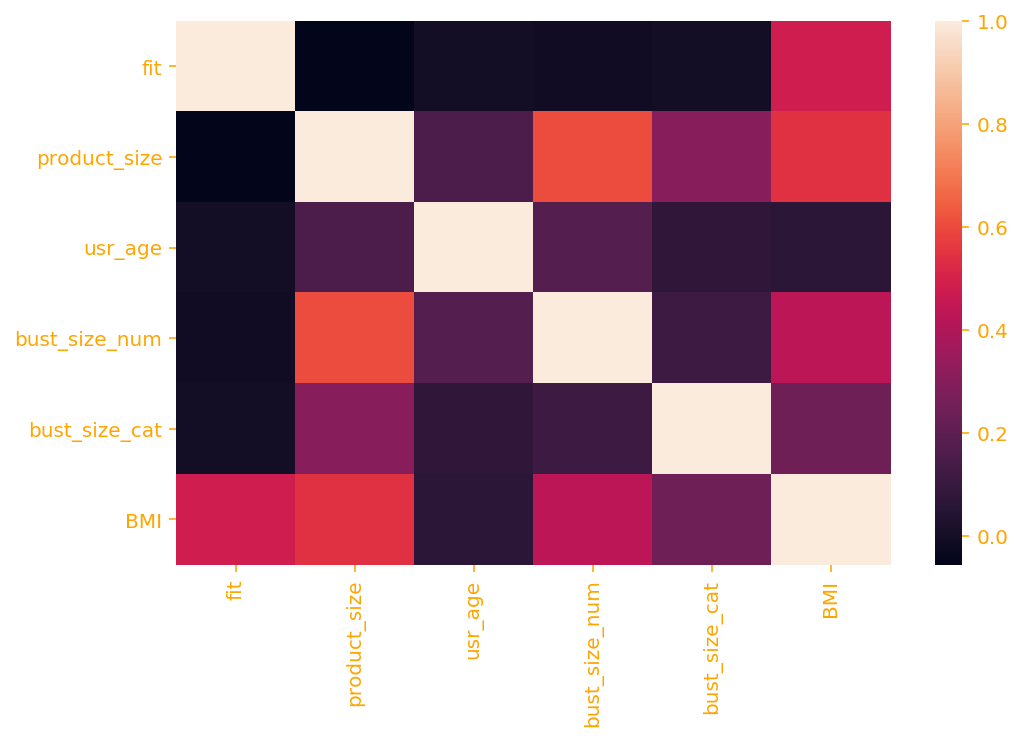

In [62]:
cleaned_df_scaled = cleaned_df[numeric_features].copy()
cleaned_df_scaled = pd.DataFrame(scale(cleaned_df_scaled), columns=numeric_features)

corr_matrix = cleaned_df_scaled.corr()
sns.heatmap(corr_matrix)
corr_matrix

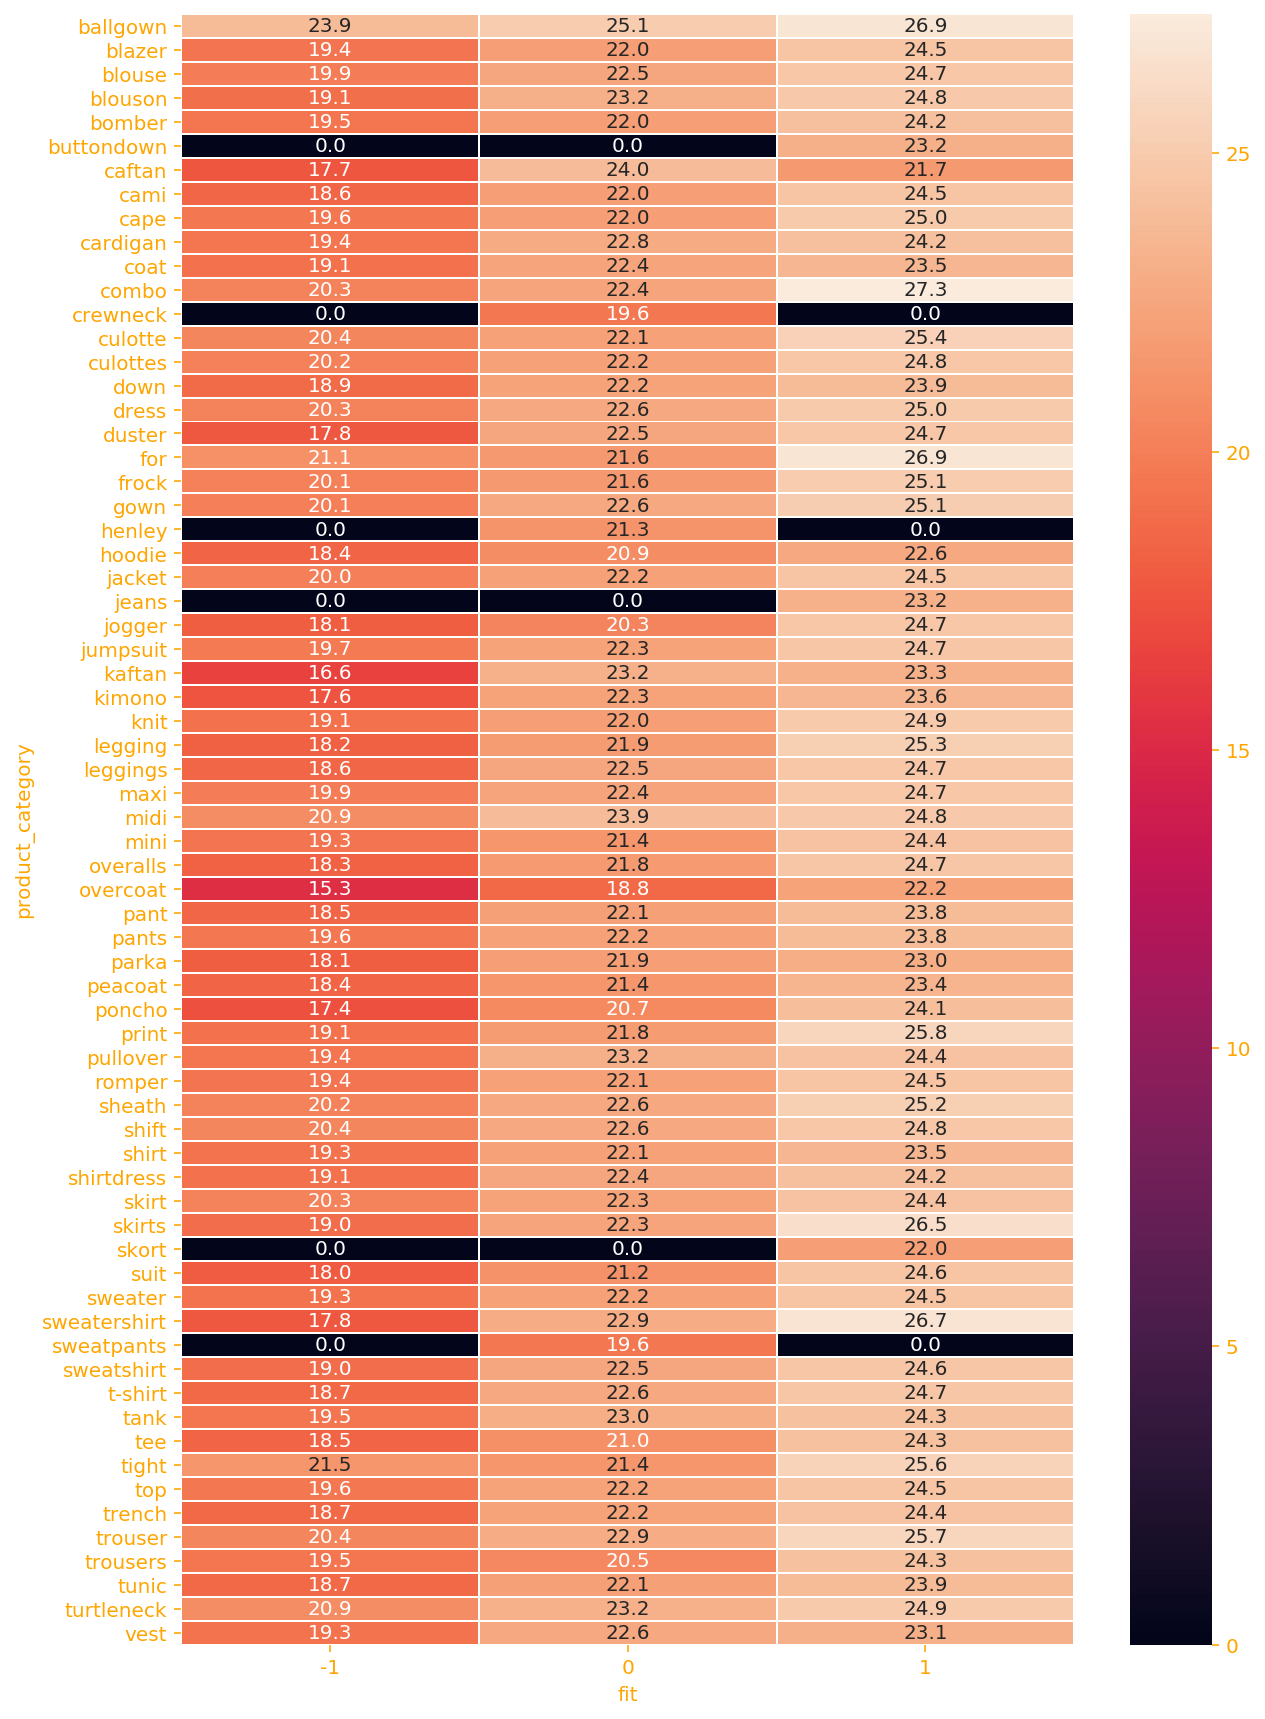

In [63]:
cat_features = ['fit', 'rented_for', 'product_category', 'body_type']

product_category_fits = cleaned_df.pivot_table(
                        index='product_category', 
                        columns='fit', 
                        values='BMI', 
                        ).fillna(0).applymap(float)
plt.figure(figsize=(10, 15))
sns.heatmap(product_category_fits, annot=True, fmt=".1f", linewidths=.5);

  # Model selection

,dress,gown,jumpsuit,maxi,other,romper,sheath,shift,top
0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


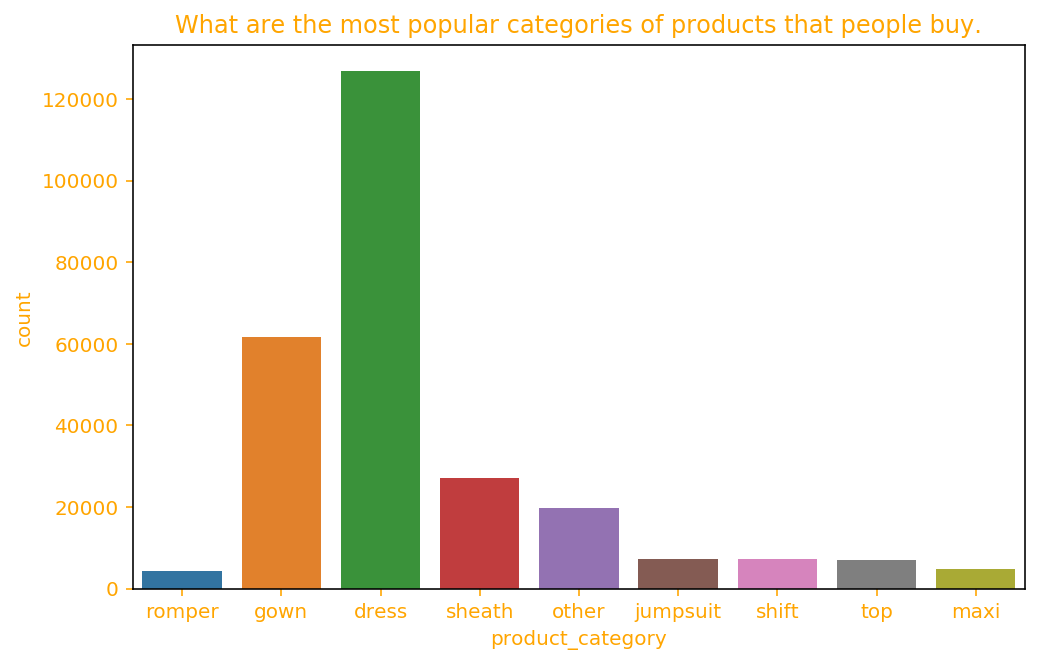

In [64]:
top_n = 8
# select top_n categories and send the rest to the top_n+1th 'others' then onehot the result
prod_cats = cleaned_df['product_category'].value_counts().index[:top_n].values
prod_cat_col = cleaned_df['product_category'].apply(lambda x: x if x in prod_cats else 'other')
plt.title('What are the most popular categories of products that people buy.')
sns.countplot(prod_cat_col)

cats_unique = prod_cat_col.unique()

prod_cat_col_encoded = pd.get_dummies(prod_cat_col)
save_labels('../app/model/txt/product_categories.txt', prod_cat_col_encoded.columns)
prod_cat_col_encoded.head()


,date,everyday,formal affair,other,party,vacation,wedding,work
0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0


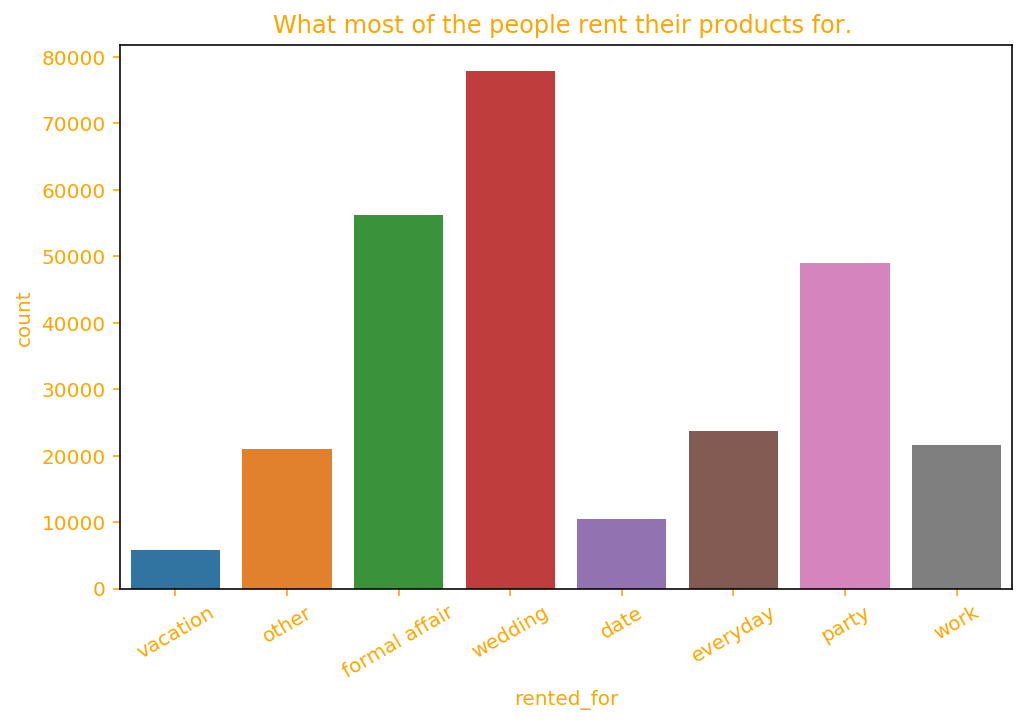

In [65]:
rented_for_col = cleaned_df['rented_for'].replace('party: cocktail', 'other')

plt.title('What most of the people rent their products for. ')
plt.xticks(rotation=30)
sns.countplot(rented_for_col)

rented_for_col_encoded = pd.get_dummies(rented_for_col)
save_labels('../app/model/txt/rented_for_categories.txt', rented_for_col_encoded.columns)
rented_for_col_encoded.head()

,apple,athletic,full bust,hourglass,pear,petite,straight & narrow
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


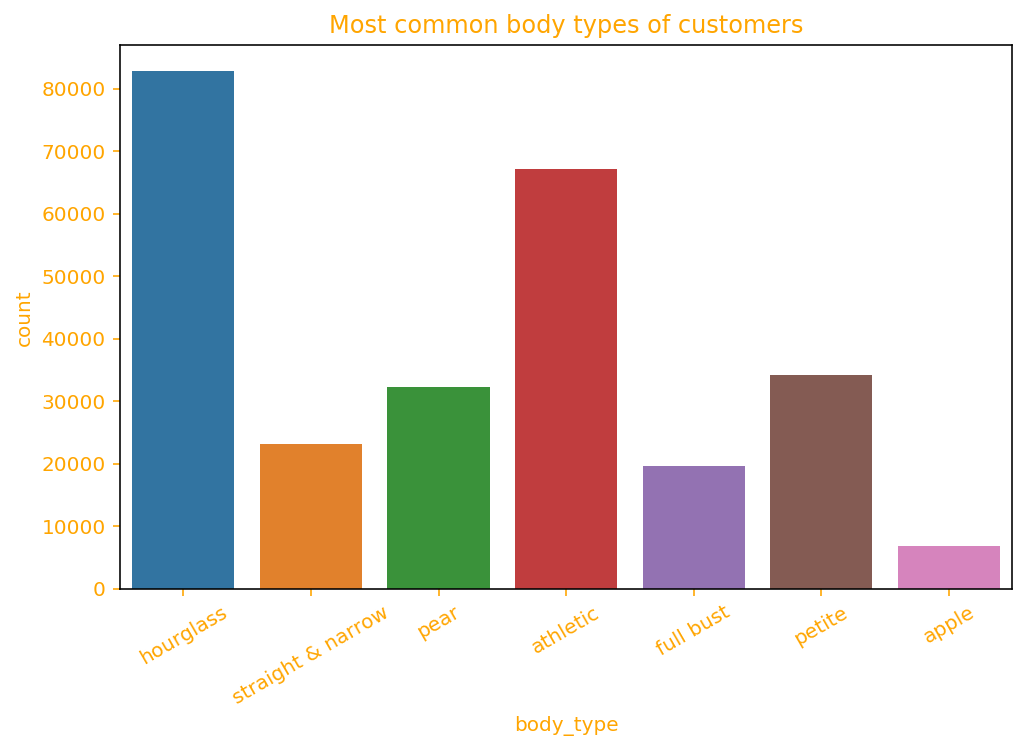

In [66]:
plt.title('Most common body types of customers')
plt.xticks(rotation=30)
body_type_col = cleaned_df['body_type']
sns.countplot(body_type_col)
body_type_col_encoded = pd.get_dummies(body_type_col)
save_labels('../app/model/txt/body_type_categories.txt', body_type_col_encoded.columns)
body_type_col_encoded.head()

Putting all pieces together and saving the ultimate dataset.

In [67]:
dummy_features_df = pd.concat((prod_cat_col_encoded, rented_for_col_encoded, body_type_col_encoded), axis=1)
dummy_features_df.head()

,dress,gown,jumpsuit,maxi,other,romper,sheath,shift,top,date,...,vacation,wedding,work,apple,athletic,full bust,hourglass,pear,petite,straight & narrow
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [68]:
from sklearn.feature_selection import VarianceThreshold

# removing all features having in 80% samples either ones or zeros
sel = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
print(dummy_features_df.shape)
dummy_features = sel.fit_transform(dummy_features_df)
print(dummy_features.shape)

(265950, 24)
(265950, 6)


In [69]:
import os


data = pd.concat((cleaned_df[numeric_features], dummy_features_df), axis=1)

head, tail = os.path.split(renththerunway_fp)
cleaned_data_fp = 'cleaned_' + tail.replace('json', 'csv')

data.to_csv(cleaned_data_fp, index=False)
data.head(3)

,fit,product_size,usr_age,bust_size_num,bust_size_cat,BMI,dress,gown,jumpsuit,maxi,...,vacation,wedding,work,apple,athletic,full bust,hourglass,pear,petite,straight & narrow
0,0,14.0,28.0,34,4,20.830565,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,12.0,36.0,34,2,21.305139,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,8.0,34.0,34,3,22.464945,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [70]:
cleaned_df[numeric_features].head(3)

,fit,product_size,usr_age,bust_size_num,bust_size_cat,BMI
0,0,14.0,28.0,34,4,20.830565
1,0,12.0,36.0,34,2,21.305139
2,0,8.0,34.0,34,3,22.464945


In [71]:
from sklearn.model_selection import train_test_split


X = np.hstack((cleaned_df[numeric_features].drop([target_feature, 'bust_size_num', 'bust_size_cat'], axis=1), dummy_features))
y = cleaned_df[target_feature].astype('float32').values
X.shape, y.shape

((265950, 9), (265950,))

In [72]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer


scorer = make_scorer(accuracy_score)
ensemble_models = [RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier]
n_estimators = 5
for model in ensemble_models:
    clf = model(n_estimators=n_estimators)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print(f"Scores: {', '.join(map(lambda n: str(round(n, 3)), scores))}. Mean: {scores.mean()}")

Scores: 0.447, 0.596, 0.782, 0.788, 0.787. Mean: 0.6798327951107507
Scores: 0.454, 0.634, 0.863, 0.863, 0.86. Mean: 0.7346292001272385
Scores: 0.406, 0.545, 0.708, 0.726, 0.717. Mean: 0.6202462566677016


In [73]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier


linear_models = [RidgeClassifier, SGDClassifier]
for model in linear_models:
    clf = model()
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
    print(f"Scores: {', '.join(map(lambda n: str(round(n, 3)), scores))}. Mean: {scores.mean()}")

Scores: 0.429, 0.739, 0.742. Mean: 0.6368765294534177
Scores: 0.44, 0.62, 0.565. Mean: 0.5415872361287754


In [74]:
from sklearn.linear_model import LogisticRegression


log_regr_params = [
    {
        'multi_class': 'multinomial', 
        'solver': 'lbfgs'
    }, 
    {
        'multi_class': 'ovr'
    }
]
for params in log_regr_params:
    clf = LogisticRegression(**params)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print(f"Scores: {', '.join(map(lambda n: str(round(n, 3)), scores))}. Mean: {scores.mean()}")

Scores: 0.425, 0.556, 0.738, 0.753, 0.7. Mean: 0.6344668982913129
Scores: 0.431, 0.565, 0.757, 0.759, 0.759. Mean: 0.6543279630076593


In [75]:
from sklearn.cluster import KMeans, MeanShift
from sklearn.neighbors import KNeighborsClassifier

clf = KMeans(3, max_iter=500)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
print(f"KMeans scores: {', '.join(map(lambda n: str(round(n, 3)), scores))}. Mean: {scores.mean()}")

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
print(f"KNearestNeighbors scores: {', '.join(map(lambda n: str(round(n, 3)), scores))}. "\
      f"Mean: {scores.mean()}")

KMeans scores: 0.267, 0.357, 0.109. Mean: 0.2441962774957699
KNearestNeighbors scores: 0.445, 0.724, 0.725. Mean: 0.6312099241402417


In [76]:
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(hidden_layer_sizes=(X.shape[1]))
print(cross_val_score(clf, X, y, cv=5))

[0.42480871 0.56915644 0.77805979 0.77422023 0.77504747]


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

print(f'Samples for training: {X_train.shape[0]}')
print(f'Samples for testing: {X_test.shape[0]}')

Samples for training: 226057
Samples for testing: 39893


## Data preprocessing before training

In [86]:
from sklearn.preprocessing import StandardScaler, RobustScaler


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

BaggingClassifier produced pretty good results. Now we can pick best parameters for it using grid search.

In [87]:
from sklearn.model_selection import GridSearchCV


params = {
    'n_estimators': [29, 30, 31, 32],
#     'criterion': ['gini', 'entropy'],
    'n_jobs': [1]
}
clf = BaggingClassifier()

optimizer = GridSearchCV(clf, params, cv=5)
optimizer.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [29, 30, 31, 32], 'n_jobs': [1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [88]:
score = optimizer.best_score_ 
params = optimizer.best_params_
print(f'Best train score: {score}')
print(f'Params: {params}')

Best train score: 0.7582335428675069
Params: {'n_estimators': 32, 'n_jobs': 1}


In [89]:
estim = optimizer.best_estimator_
test_preds = estim.predict(scaler.transform(X_test))
score = accuracy_score(y_test, test_preds)
print(f'Test score: {score}')

Test score: 0.7639184819391873


In [90]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, test_preds)
labels = ['small', 'fit', 'large']
pd.DataFrame(data=conf_matrix, index=labels, columns=labels)

,small,fit,large
small,8826,2493,591
fit,1598,12980,1628
large,598,2510,8669


In [91]:
from joblib import dump, load


dump(scaler, '../app/model/scaler.joblib') 
dump(sel, '../app/model/bool_var_th.joblib')
dump(estim, '../app/model/model.joblib');

Let's measure loading time of preprocessors and model.

In [92]:
%%timeit
load('../app/model/scaler.joblib')

354 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [93]:
%%timeit
load('../app/model/model.joblib')

387 ms ± 52.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
